In [1]:
import jax
import jax.numpy as jnp
import optax


import matplotlib.pyplot as plt
import numpy as np


from tqdm import tqdm as tqdm
import pandas as pd

In [2]:
def generate_gaussian_samples(mu, cov, n_samples, seed=0):


    d = mu.shape[0]
    key = jax.random.PRNGKey(seed)
    z = jax.random.normal(key, shape=(n_samples, d))


    L = jnp.linalg.cholesky(cov)
    samples = mu + z @ L.T
    
    
    return samples

In [3]:
def potential_grad(sample, mu, cov):


    precision = jnp.linalg.inv(cov)


    return (sample - mu) @ precision

In [4]:
def evolve_langevin(samples, mu, cov, eps=1e-2, n_evolution=100, seed=0):

    
    key = jax.random.PRNGKey(seed)
    evolved_samples = samples


    for i in range(n_evolution):
        key, subkey = jax.random.split(key)
        grad = potential_grad(evolved_samples, mu, cov)
        noise = jax.random.normal(subkey, shape=evolved_samples.shape)
        evolved_samples = evolved_samples - eps * grad + jnp.sqrt(2 * eps) * noise
        

    return evolved_samples

In [ ]:
def sample_unit_directions(key, d, n_proj):
    rand = jax.random.normal(key, shape=(n_proj, d))
    return rand / jnp.linalg.norm(rand, axis=1, keepdims=True)

def empirical_histogram(x, bins):
    hist, _ = jnp.histogram(x, bins=bins, density=True)
    hist += 1e-8
    hist /= jnp.sum(hist)
    return hist

def empirical_kl_1d(p, q):
    return jnp.sum(p * jnp.log(p / q))

def compute_projection_kl(samples, evolved_samples, direction, n_bins=100):
    proj_samples = samples @ direction
    proj_evolved = evolved_samples @ direction

    min_val = jnp.minimum(jnp.min(proj_samples), jnp.min(proj_evolved))
    max_val = jnp.maximum(jnp.max(proj_samples), jnp.max(proj_evolved))
    bins = jnp.linspace(min_val, max_val, n_bins + 1)

    hist_p = empirical_histogram(proj_samples, bins)
    hist_q = empirical_histogram(proj_evolved, bins)

    return empirical_kl_1d(hist_p, hist_q)

def sliced_kl_divergence(samples1, samples2, n_proj=100, n_bins=100, key=jax.random.PRNGKey(0)):
    d = samples1.shape[1]
    directions = sample_unit_directions(key, d, n_proj)  # (n_proj, d)

    def kl_dir(dir):
        return compute_projection_kl(samples1, samples2, dir, n_bins)

    kl_values = jax.vmap(kl_dir)(directions)
    return jnp.mean(kl_values)


In [6]:
def lm_loss(samples, mu, cov):


    evolved_samples = evolve_langevin(samples, mu, cov)


    return sliced_kl_divergence(samples, evolved_samples)

In [7]:
def lm_optimize_with_tracking(
    samples,
    true_mu,
    true_cov,
    n_epochs=1000,
    base_lr=1e-2,
    seed=10,
    eps=1e-2,
    plot_every=2,
    use_lr_schedule=True
):
    

    n, d = samples.shape


    key = jax.random.PRNGKey(seed)
    key_mu, key_A = jax.random.split(key)


    mu = jax.random.normal(key_mu, shape=(d,))
    A = jax.random.normal(key_A, shape=(d, d))


    params = {
        "mu": mu,
        "A": A
    }


    if use_lr_schedule:
        lr_schedule = optax.linear_schedule(
            init_value=1e-2,
            end_value=base_lr,
            transition_steps=500
        )
        optimizer = optax.adam(learning_rate=lr_schedule)
    else:
        optimizer = optax.adam(learning_rate=base_lr)


    opt_state = optimizer.init(params)


    def loss_fn(params, samples):
        mu = params["mu"]
        A = params["A"]
        cov = A.T @ A
        return lm_loss(samples, mu, cov)


    history = {
        "loss": [],
        "mu_l2": [],
        "cov_fro": [],
    }


    for epoch in range(n_epochs):
        loss_val, grads = jax.value_and_grad(loss_fn)(params, samples)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)


        mu_val = params["mu"]
        A_val = params["A"]
        cov_val = A_val.T @ A_val


        history["loss"].append(loss_val)
        history["mu_l2"].append(jnp.linalg.norm(true_mu - mu_val))
        history["cov_fro"].append(jnp.linalg.norm(true_cov - cov_val, ord='fro'))


        if epoch % plot_every == 0 or epoch == n_epochs - 1:
            print(f"epoch {epoch} | loss = {loss_val:.6f}")


    final_mu = params["mu"]
    final_cov = params["A"].T @ params["A"]


    return final_mu, final_cov, history

In [8]:
mu = jnp.array([1.0])


cov = jnp.array([
[1.0]
])

In [9]:
samples = generate_gaussian_samples(mu, cov, n_samples=2000, seed=0)


final_mu, final_cov, history = lm_optimize_with_tracking(samples, mu, cov, n_epochs=800, base_lr=0.1, seed = 0)

epoch 0 | loss = 0.195086
epoch 2 | loss = 0.195152
epoch 4 | loss = 0.195074
epoch 6 | loss = 0.194948
epoch 8 | loss = 0.195186
epoch 10 | loss = 0.197729
epoch 12 | loss = 0.198778
epoch 14 | loss = 0.197977
epoch 16 | loss = 0.199738
epoch 18 | loss = 0.200250
epoch 20 | loss = 0.200940
epoch 22 | loss = 0.199138
epoch 24 | loss = 0.199477
epoch 26 | loss = 0.207077
epoch 28 | loss = 0.209292
epoch 30 | loss = 0.209905
epoch 32 | loss = 0.204946
epoch 34 | loss = 0.207155
epoch 36 | loss = 0.207784
epoch 38 | loss = 0.209303
epoch 40 | loss = 0.208175
epoch 42 | loss = 0.208813
epoch 44 | loss = 0.209279
epoch 46 | loss = 0.209493
epoch 48 | loss = 0.209811
epoch 50 | loss = 0.209543
epoch 52 | loss = 0.209897
epoch 54 | loss = 0.210572
epoch 56 | loss = 0.209908
epoch 58 | loss = 0.209556
epoch 60 | loss = 0.209445
epoch 62 | loss = 0.209385
epoch 64 | loss = 0.209445
epoch 66 | loss = 0.209242
epoch 68 | loss = 0.209242
epoch 70 | loss = 0.209304
epoch 72 | loss = 0.209363
epoch 

In [10]:
jnp.set_printoptions(precision=4, suppress=True)


print(jnp.round(mu, 4), "\n\n", jnp.round(final_mu, 4), jnp.linalg.norm(mu - final_mu)/jnp.linalg.norm(mu), "\n\n\n")
print(jnp.round(cov, 4), "\n\n", jnp.round(final_cov, 4), jnp.linalg.norm(cov - final_cov)/jnp.linalg.norm(cov), "\n\n\n")

[1.] 

 [0.1987] 0.80129135 



[[1.]] 

 [[10.7438]] 9.743798 





In [11]:
history_np = {k: np.array(v) for k, v in history.items()}

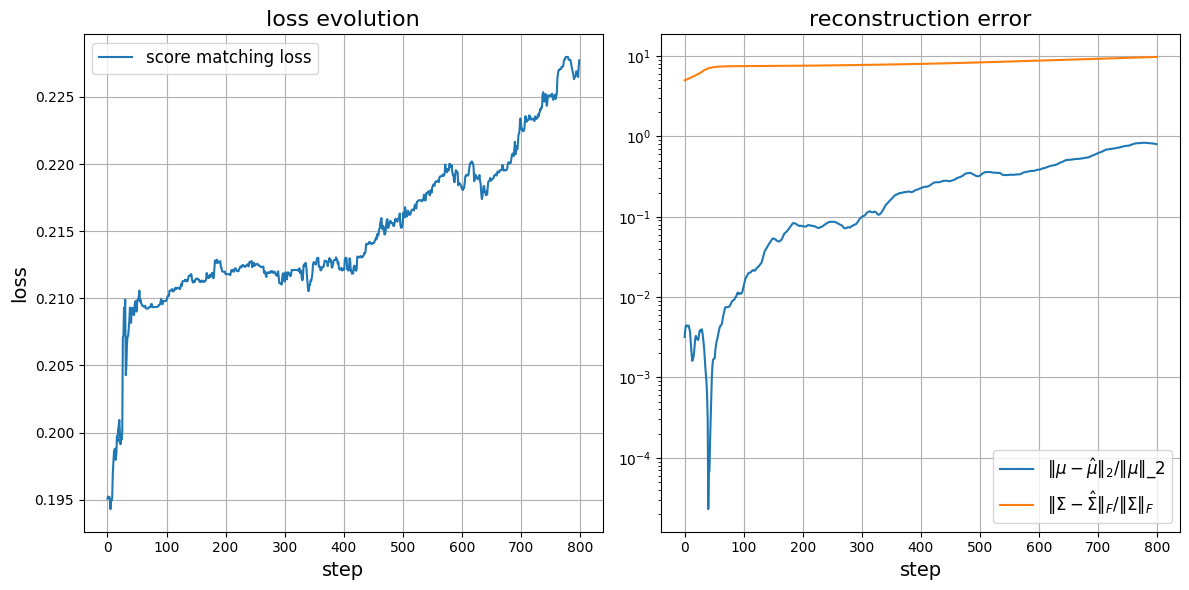

In [12]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history_np["loss"], label="score matching loss")
plt.xlabel("step", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.title("loss evolution", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)


plt.subplot(1, 2, 2)
plt.plot(history_np["mu_l2"]/np.linalg.norm(mu), label=r"$\| \mu - \hat{\mu} \|_2/\|\mu\|\_2$")
plt.plot(history_np["cov_fro"]/np.linalg.norm(cov), label=r"$\| \Sigma - \hat{\Sigma} \|_F/\|\Sigma\|_F$")
plt.yscale("log")
plt.xlabel("step", fontsize=14)
plt.title("reconstruction error", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)


plt.tight_layout()
plt.show()

In [13]:
sample_sizes = np.arange(50, 2001, 50)
n_steps = 800


all_losses = []
all_mu_errors = []
all_cov_errors = []


for n in tqdm(sample_sizes):
    samples = generate_gaussian_samples(mu, cov, n, seed=0)
    _, _, history = lm_optimize_with_tracking(samples, mu, cov, n_epochs=n_steps, base_lr=0.1, seed = 0)
    all_losses.append(np.array(history["loss"]))
    all_mu_errors.append(np.array(history["mu_l2"]))
    all_cov_errors.append(np.array(history["cov_fro"]))

  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0 | loss = 10.019209
epoch 2 | loss = 10.322172
epoch 4 | loss = 9.340995
epoch 6 | loss = 9.375873
epoch 8 | loss = 8.307132
epoch 10 | loss = 8.987997
epoch 12 | loss = 8.653209
epoch 14 | loss = 9.013915
epoch 16 | loss = 9.360689
epoch 18 | loss = 9.359756
epoch 20 | loss = 8.983498
epoch 22 | loss = 8.295593
epoch 24 | loss = 8.294801
epoch 26 | loss = 7.984718
epoch 28 | loss = 8.369650
epoch 30 | loss = 8.374663
epoch 32 | loss = 8.401658
epoch 34 | loss = 8.400941
epoch 36 | loss = 8.709394
epoch 38 | loss = 8.708673
epoch 40 | loss = 8.707963
epoch 42 | loss = 9.374038
epoch 44 | loss = 8.976364
epoch 46 | loss = 8.991871
epoch 48 | loss = 8.991175
epoch 50 | loss = 8.990491
epoch 52 | loss = 8.670427
epoch 54 | loss = 8.642080
epoch 56 | loss = 8.641473
epoch 58 | loss = 8.668603
epoch 60 | loss = 8.668031
epoch 62 | loss = 8.691802
epoch 64 | loss = 8.330433
epoch 66 | loss = 8.329925
epoch 68 | loss = 8.326040
epoch 70 | loss = 8.325565
epoch 72 | loss = 7.992092
epoc

  2%|▎         | 1/40 [02:40<1:44:25, 160.65s/it]

epoch 799 | loss = 10.401490
epoch 0 | loss = 2.870347
epoch 2 | loss = 4.196139
epoch 4 | loss = 4.202686
epoch 6 | loss = 4.211460
epoch 8 | loss = 4.185167
epoch 10 | loss = 4.190008
epoch 12 | loss = 4.018967
epoch 14 | loss = 4.334473
epoch 16 | loss = 3.866211
epoch 18 | loss = 3.833165
epoch 20 | loss = 4.799667
epoch 22 | loss = 4.628367
epoch 24 | loss = 4.598386
epoch 26 | loss = 4.430023
epoch 28 | loss = 4.739335
epoch 30 | loss = 4.570001
epoch 32 | loss = 4.738722
epoch 34 | loss = 4.749853
epoch 36 | loss = 4.422258
epoch 38 | loss = 4.595689
epoch 40 | loss = 3.961984


  2%|▎         | 1/40 [02:48<1:49:45, 168.87s/it]

epoch 42 | loss = 4.130891


KeyboardInterrupt: 

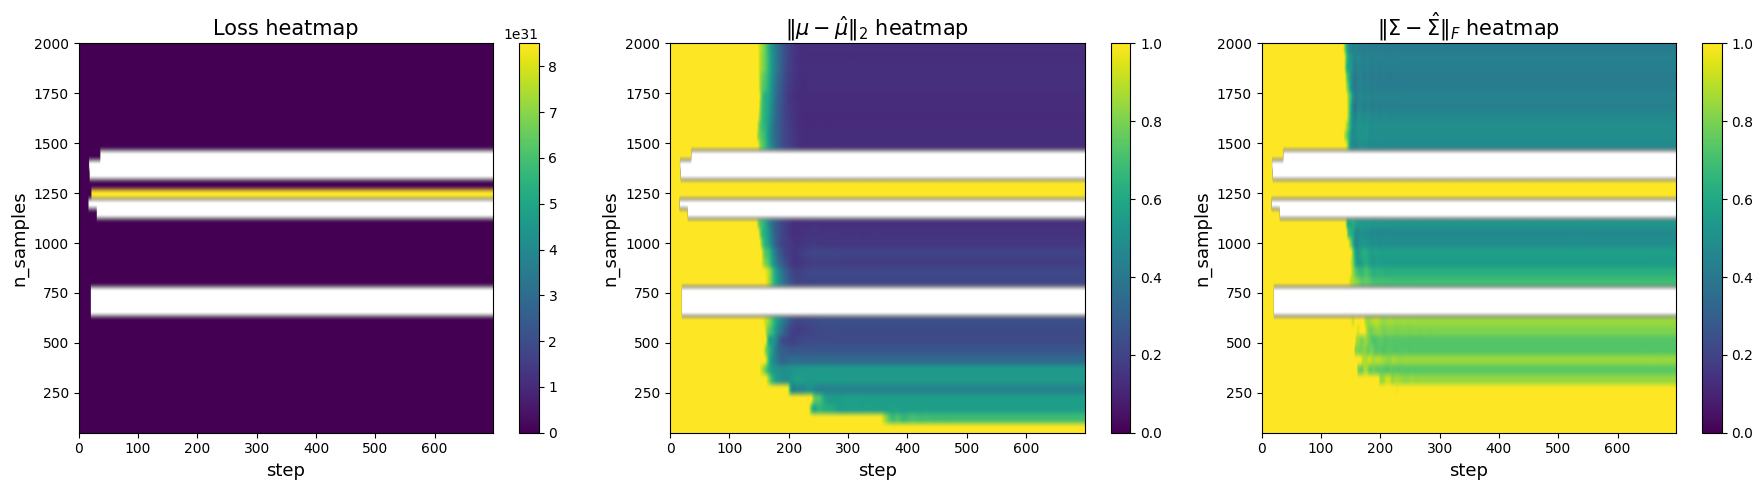

In [ ]:
loss_matrix = np.array(all_losses)
mu_err_matrix = np.array(all_mu_errors)/np.linalg.norm(mu)
cov_err_matrix = np.array(all_cov_errors)/np.linalg.norm(cov)


steps = np.linspace(0, n_steps, n_steps)
sample_sizes = np.arange(50, 2001, 50)


def plot_heatmap(data, title, ylabel, cmap="viridis", vmin=None, vmax=None):
    plt.imshow(data, aspect="auto", origin="lower", cmap=cmap,
               extent=[steps[0], steps[-1], sample_sizes[0], sample_sizes[-1]],
               vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.xlabel("step", fontsize=13)
    plt.ylabel("n_samples", fontsize=13)
    plt.title(title, fontsize=15)


plt.figure(figsize=(18, 5))


plt.subplot(1, 3, 1)
plot_heatmap(loss_matrix, "Loss heatmap", "n_samples")


plt.subplot(1, 3, 2)
plot_heatmap(mu_err_matrix, r"$\|\mu - \hat{\mu}\|_2/\|\mu\|_2$ heatmap", "n_samples", vmin=0.0, vmax=1.0)


plt.subplot(1, 3, 3)
plot_heatmap(cov_err_matrix, r"$\|\Sigma - \hat{\Sigma}\|_F/\|\Sigma\|_F$ heatmap", "n_samples", vmin=0.0, vmax=1.0)


plt.tight_layout()
plt.show()